In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ray import train, tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import mean_absolute_error


In [2]:
file_path = "/mnt/12TB/jet_omer/cms_jet_data.h5"
key = "data"
data = pd.read_hdf(file_path, key=key)

df = pd.DataFrame(data)
df_filtered = df[df["jetGenMatch"] != 0]
df_filtered = df_filtered.head(1000000)

exclude_columns = ["genJetPt", "jetRawPt", "jetGenMatch"]

In [3]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


features = df_filtered[[col for col in df_filtered.columns if col not in exclude_columns]]
target = df_filtered["genJetPt"]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features_scaled, target, test_size=0.4, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_validation, label=y_validation)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'alpha': 0,
    'n_estimators': 100,
}

# Define the hyperparameters grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100, 150],
}

# Create XGBoost regressor
xgb_regressor = xgb.XGBRegressor(**params)

# Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
grid_search.fit(features_scaled, target)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative Mean Absolute Error:", grid_search.best_score_)

# Get the best model from the grid search
best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
Best Negative Mean Absolute Error: -16.00969473520915


In [7]:
best_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}

# Update the params dictionary
params.update(best_params)

evals_result = {}

# Train the final model with the best parameters
final_model = xgb.train(params, dtrain, num_boost_round=150, evals=[(dtrain, 'train'), (dvalid, 'valid')], evals_result=evals_result, early_stopping_rounds=10, verbose_eval=True)

[0]	train-rmse:268.43765	valid-rmse:267.32432
[1]	train-rmse:247.14792	valid-rmse:246.24030
[2]	train-rmse:228.40164	valid-rmse:227.72885
[3]	train-rmse:206.19191	valid-rmse:205.54342


/home/odokumaci/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [00:06:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	train-rmse:186.26614	valid-rmse:185.64032
[5]	train-rmse:170.17145	valid-rmse:169.70032
[6]	train-rmse:154.01904	valid-rmse:153.59338
[7]	train-rmse:139.49237	valid-rmse:139.11108
[8]	train-rmse:126.52963	valid-rmse:126.20684
[9]	train-rmse:114.89317	valid-rmse:114.62558
[10]	train-rmse:104.49487	valid-rmse:104.29204
[11]	train-rmse:95.29617	valid-rmse:95.15878
[12]	train-rmse:87.12971	valid-rmse:87.07065
[13]	train-rmse:79.80689	valid-rmse:79.81501
[14]	train-rmse:74.20171	valid-rmse:74.34411
[15]	train-rmse:68.33330	valid-rmse:68.60174
[16]	train-rmse:63.16091	valid-rmse:63.56027
[17]	train-rmse:59.36218	valid-rmse:59.96782
[18]	train-rmse:55.35286	valid-rmse:56.11720
[19]	train-rmse:51.76885	valid-rmse:52.75849
[20]	train-rmse:48.62942	valid-rmse:49.83026
[21]	train-rmse:46.94731	valid-rmse:48.36058
[22]	train-rmse:44.98002	valid-rmse:46.63307
[23]	train-rmse:42.83825	valid-rmse:44.70326
[24]	train-rmse:41.43510	valid-rmse:43.54134
[25]	train-rmse:39.80197	valid-rmse:42.12744
[2

Mean Absolute Error on test set (XGBoost): 16.076862335205078


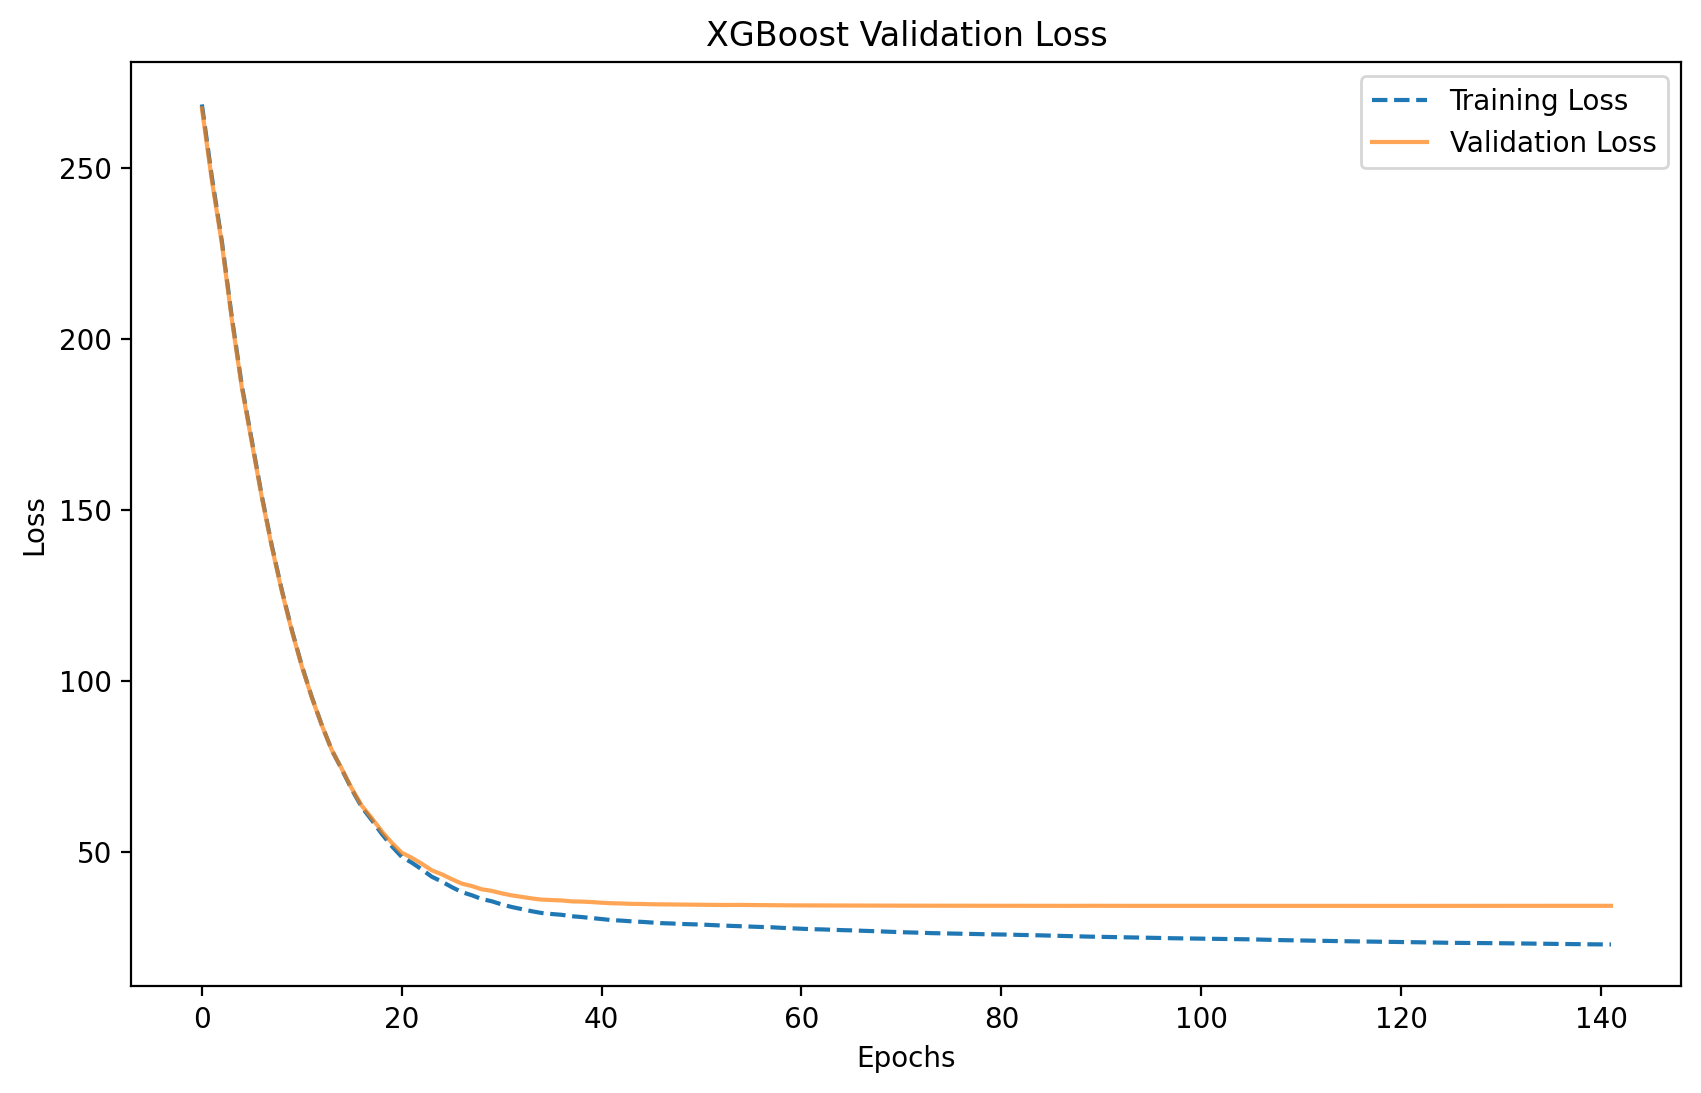

In [8]:
y_pred = final_model.predict(dtest)



#mae_xgb = mean_absolute_error(y_test, y_pred)
mae_xgb = np.mean(np.abs(y_test - y_pred))
print(f'Mean Absolute Error on test set (XGBoost): {mae_xgb}')



train_mae = evals_result['train']['rmse']
valid_mae = evals_result['valid']['rmse']

plt.figure(figsize=(10, 6))

plt.plot(train_mae, label='Training Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('XGBoost Training Loss')
plt.legend()

plt.plot(valid_mae, label='Validation Loss', alpha = 0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('XGBoost Validation Loss')
plt.legend()

plt.show()

In [9]:
X_test_original_scale = scaler.inverse_transform(X_test)

def bin_ratio(rawjet_hist, genjet_hist):
    
    _, bin_edges = np.histogram(genjet_hist, bins='auto')

    ratios = []
    mean_list = []
    std_list = []

    for ibin in range(len(bin_edges) - 1):
        idx = (rawjet_hist >= bin_edges[ibin]) & (rawjet_hist <= bin_edges[ibin + 1])  # boolean mask
        ratios.append((rawjet_hist[idx] - 0 * genjet_hist[idx]) / genjet_hist[idx])

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for hist in ratios:
        mean_list.append(np.mean(hist))
        std_list.append(np.std(hist))

    return np.array(mean_list), np.array(std_list), bin_centers, bin_edges



rawtogen_mean, rawtogen_std, bin_centers, bin_edges = bin_ratio(X_test_original_scale[:, 0], y_test)
corrtogen_mean, corrtogen_std, _, _ = bin_ratio(y_pred.flatten(), y_test)




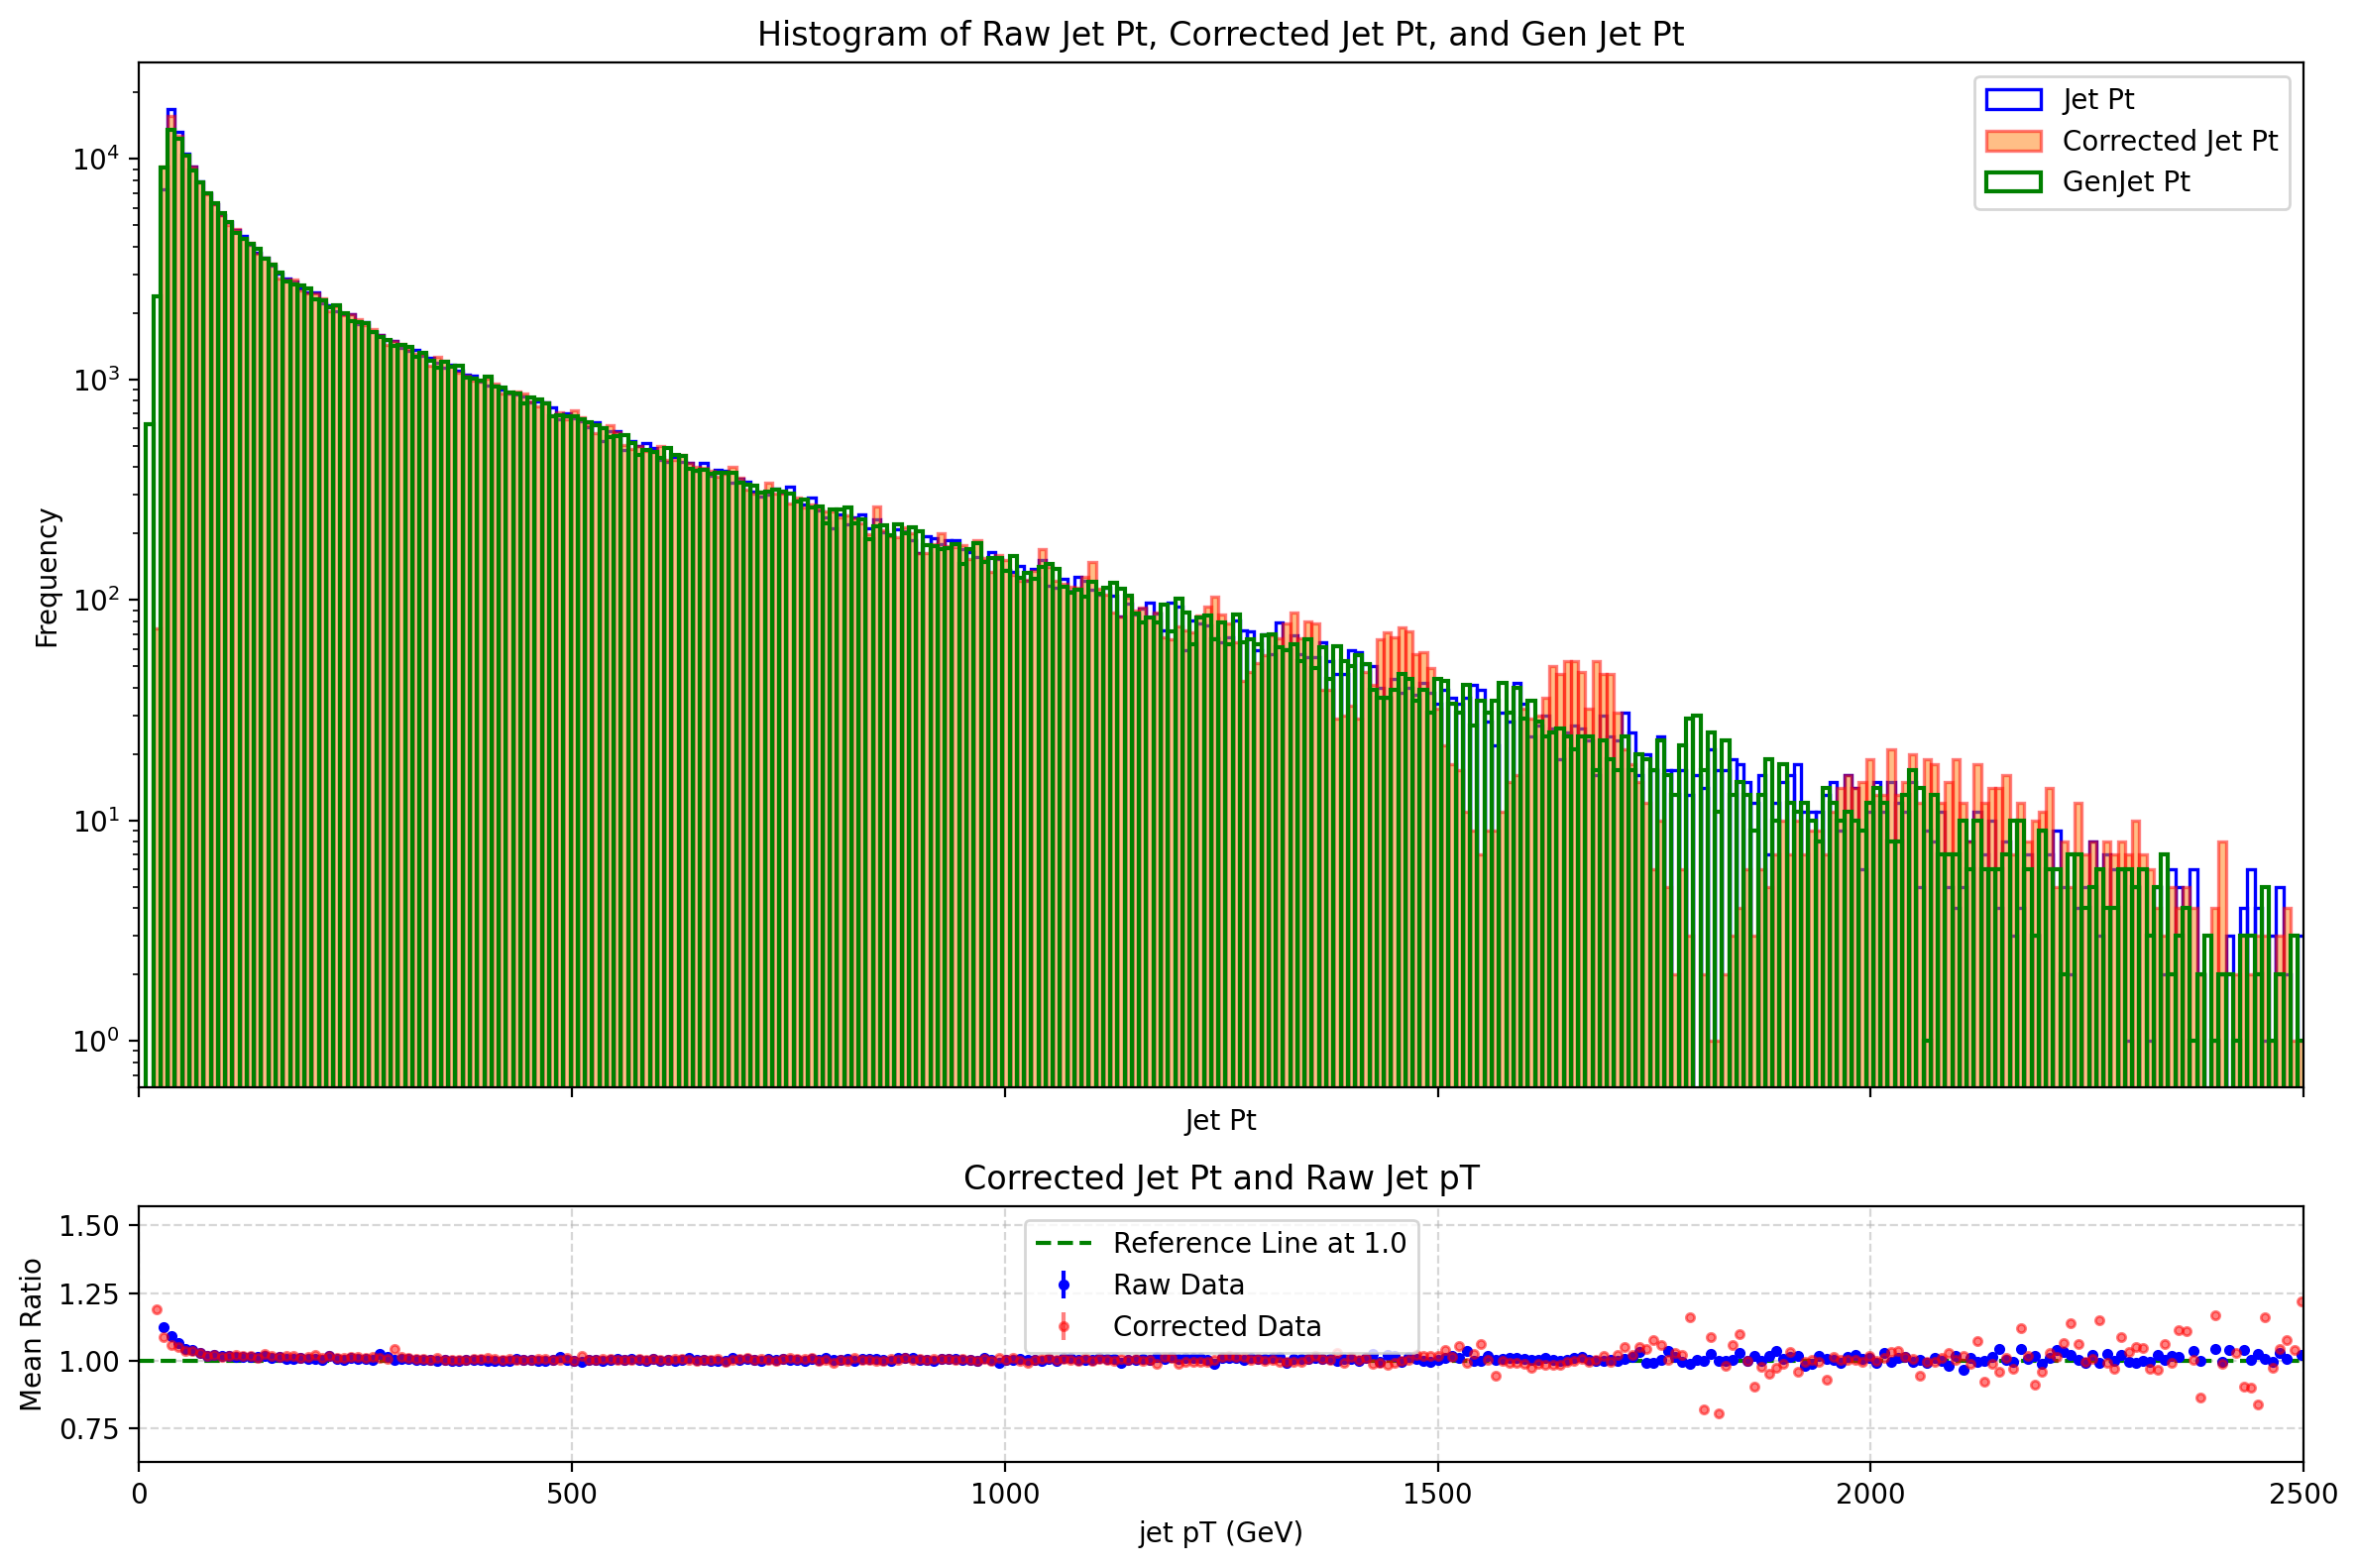

In [10]:
# Plotting the histogram and ratio plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [4, 1]}, figsize=(12, 8))


#common_bin_edges = np.linspace(min(X_test_original_scale[:, 0].min(), y_pred.min(), y_test.min()), max(X_test_original_scale[:, 0].max(), y_pred.max(), y_test.max()), 100)


ax1.hist(X_test_original_scale[:, 0], bins=bin_edges, label='Jet Pt', fill=0, edgecolor='blue', linewidth=1.2)
ax1.hist(y_pred, bins=bin_edges, label='Corrected Jet Pt', edgecolor="red", alpha=0.5, linewidth=1.2)
ax1.hist(y_test, bins=bin_edges, label='GenJet Pt', fill=0, edgecolor='green', linewidth=1.5)

ax1.set_xlabel('Jet Pt')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Raw Jet Pt, Corrected Jet Pt, and Gen Jet Pt')
ax1.set_yscale('log')
ax1.legend()


ax2.errorbar(bin_centers, rawtogen_mean, yerr=0 * rawtogen_std, fmt='o', markersize=3.0, color='blue', label='Raw Data')
ax2.errorbar(bin_centers, corrtogen_mean, yerr=0 * corrtogen_std, fmt='o', markersize=3.0, alpha=0.5, color='red',
             label='Corrected Data')
ax2.axhline(y=1.0, color='g', linestyle='--', label='Reference Line at 1.0')

ax2.set_xlabel('jet pT (GeV)')
ax2.set_ylabel('Mean Ratio')
ax2.set_title('Corrected Jet Pt and Raw Jet pT')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

ax1.set_xlim(0, 2500)
ax2.set_xlim(0, 2500)

plt.tight_layout()
plt.show()